# Generating Unique Artworks using GANs

GANs are a class of deep neural networks consisting of two neural networks competing against each other. We have the generator and discriminator.
In this tutorial, we will be generating unique artworks using GANs. These artworks can be used as wall canvas, graffitis or even album covers.

### Importing the libraries

In [41]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import helper
from glob import glob
import pickle as pkl
import scipy.misc
import time

# We will be using tensorflow v1 
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

preprocess = True # change if converting image size
from_checkpoint = False

### Data
- We are using the [wikiarts](https://www.wikiart.org/en/paintings-by-genre/abstract?select=featured#!#filterName:featured,viewType:masonry) data. Download the dataset [here](https://drive.google.com/file/d/18AX8LxqzbcBoW1PYKj_mz8R3EAp_q5wI/view?usp=sharing).
- Change `do_preprocess = True` to resize the images.

### Resize images to 128x128

In [42]:
data_dir = './data/' # Data
resized_data_dir = "./resized_data"# Resized data

if preprocess == True:
    # Create resized folder if not exist
    if not os.path.exists(resized_data_dir):
        os.mkdir(resized_data_dir)

    for each in os.listdir(data_dir):
        # Read the image
        image = cv2.imread(os.path.join(data_dir, each))
        image = cv2.resize(image, (128, 128))
        cv2.imwrite(os.path.join(resized_data_dir, each), image)

### Explore the data

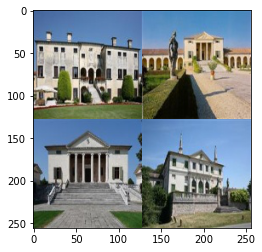

In [43]:
show_images = 5
data_images = helper.get_batch(glob(os.path.join(resized_data_dir, '*.jpg'))[:show_images], 64, 64, 'RGB')
plt.imshow(helper.images_square_grid(data_images, 'RGB'))

## DCGAN Architecture

### Input to the network
Create TF placeholders for the Neural Network:
- Real input images placeholder `real_dim`.
- Z input placeholder `z_dim`.
- Learning rate G placeholder.
- Learning rate D placeholder.
<br>

In [25]:
def gan_model_inputs(real_dim, z_dim):
    """
    Create the inputs for the model
    :param real_dim: tuple containing width, height and channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate G, learning rate D)
    """
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate_G = tf.placeholder(tf.float32, name="learning_rate_G")
    learning_rate_D = tf.placeholder(tf.float32, name="learning_rate_D")
    
    return inputs_real, inputs_z, learning_rate_G, learning_rate_D


### The Generator Network


In [26]:
def generator(z, output_channel_dim, is_train=True):
    ''' Building the generator network.
    
        Arguments
        ---------
        z : Input tensor for the generator
        output_channel_dim : Shape of the generator output
        n_units : Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out: 
    '''
    with tf.variable_scope("generator", reuse= not is_train):
        
        # First FC layer --> 8x8x1024
        fc1 = tf.layers.dense(z, 8*8*1024)
        
        # Reshape the layer
        fc1 = tf.reshape(fc1, (-1, 8, 8, 1024))
        
        # Leaky ReLU Activation
        fc1 = tf.nn.leaky_relu(fc1, alpha=alpha)

        
        # Transposed conv 1 --> BatchNorm --> LeakyReLU
        # 8x8x1024 --> 16x16x512
        trans_conv1 = tf.layers.conv2d_transpose(inputs = fc1,
                                  filters = 512,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="trans_conv1")
        
        batch_trans_conv1 = tf.layers.batch_normalization(inputs = trans_conv1, training=is_train, epsilon=1e-5, name="batch_trans_conv1")
       
        trans_conv1_out = tf.nn.leaky_relu(batch_trans_conv1, alpha=alpha, name="trans_conv1_out")
        
        
        # Transposed conv 2 --> BatchNorm --> LeakyReLU
        # 16x16x512 --> 32x32x256
        trans_conv2 = tf.layers.conv2d_transpose(inputs = trans_conv1_out,
                                  filters = 256,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="trans_conv2")
        
        batch_trans_conv2 = tf.layers.batch_normalization(inputs = trans_conv2, training=is_train, epsilon=1e-5, name="batch_trans_conv2")
       
        trans_conv2_out = tf.nn.leaky_relu(batch_trans_conv2, alpha=alpha, name="trans_conv2_out")
        
        
        # Transposed conv 3 --> BatchNorm --> LeakyReLU
        # 32x32x256 --> 64x64x128
        trans_conv3 = tf.layers.conv2d_transpose(inputs = trans_conv2_out,
                                  filters = 128,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="trans_conv3")
        
        batch_trans_conv3 = tf.layers.batch_normalization(inputs = trans_conv3, training=is_train, epsilon=1e-5, name="batch_trans_conv3")
       
        trans_conv3_out = tf.nn.leaky_relu(batch_trans_conv3, alpha=alpha, name="trans_conv3_out")

        
        # Transposed conv 4 --> BatchNorm --> LeakyReLU
        # 64x64x128 --> 128x128x64
        trans_conv4 = tf.layers.conv2d_transpose(inputs = trans_conv3_out,
                                  filters = 64,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="trans_conv4")
        
        batch_trans_conv4 = tf.layers.batch_normalization(inputs = trans_conv4, training=is_train, epsilon=1e-5, name="batch_trans_conv4")
       
        trans_conv4_out = tf.nn.leaky_relu(batch_trans_conv4, alpha=alpha, name="trans_conv4_out")

        
        # Transposed conv 5 --> tanh
        # 128x128x64 --> 128x128x3
        logits = tf.layers.conv2d_transpose(inputs = trans_conv4_out,
                                  filters = 3,
                                  kernel_size = [5,5],
                                  strides = [1,1],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="logits")
         
        out = tf.tanh(logits, name="out")
        
        return out

### Discriminator

In [27]:
def discriminator(x, is_reuse=False, alpha = 0.2):
    ''' Build the discriminator network.
    
        Arguments
        ---------
        x : Input tensor for the discriminator
        n_units: Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope("discriminator", reuse = is_reuse): 
        
        # Input layer 128*128*3 --> 64x64x64
        # Conv --> BatchNorm --> LeakyReLU   
        conv1 = tf.layers.conv2d(inputs = x,
                                filters = 64,
                                kernel_size = [5,5],
                                strides = [2,2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv1')
        
        batch_norm1 = tf.layers.batch_normalization(conv1,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm1')

        conv1_out = tf.nn.leaky_relu(batch_norm1, alpha=alpha, name="conv1_out")
        
        
        # 64x64x64--> 32x32x128
        # Conv --> BatchNorm --> LeakyReLU   
        conv2 = tf.layers.conv2d(inputs = conv1_out,
                                filters = 128,
                                kernel_size = [5, 5],
                                strides = [2, 2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv2')
        
        batch_norm2 = tf.layers.batch_normalization(conv2,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm2')
        
        conv2_out = tf.nn.leaky_relu(batch_norm2, alpha=alpha, name="conv2_out")

        
        
        # 32x32x128 --> 16x16x256
        # Conv --> BatchNorm --> LeakyReLU   
        conv3 = tf.layers.conv2d(inputs = conv2_out,
                                filters = 256,
                                kernel_size = [5, 5],
                                strides = [2, 2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv3')
        
        batch_norm3 = tf.layers.batch_normalization(conv3,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                name = 'batch_norm3')
        
        conv3_out = tf.nn.leaky_relu(batch_norm3, alpha=alpha, name="conv3_out")

        
        
        # 16x16x256 --> 16x16x512
        # Conv --> BatchNorm --> LeakyReLU   
        conv4 = tf.layers.conv2d(inputs = conv3_out,
                                filters = 512,
                                kernel_size = [5, 5],
                                strides = [1, 1],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv4')
        
        batch_norm4 = tf.layers.batch_normalization(conv4,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                name = 'batch_norm4')
        
        conv4_out = tf.nn.leaky_relu(batch_norm4, alpha=alpha, name="conv4_out")

        
        
        # 16x16x512 --> 8x8x1024
        # Conv --> BatchNorm --> LeakyReLU   
        conv5 = tf.layers.conv2d(inputs = conv4_out,
                                filters = 1024,
                                kernel_size = [5, 5],
                                strides = [2, 2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv5')
        
        batch_norm5 = tf.layers.batch_normalization(conv5,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                name = 'batch_norm5')
        
        conv5_out = tf.nn.leaky_relu(batch_norm5, alpha=alpha, name="conv5_out")

         
        # Flatten it
        flatten = tf.reshape(conv5_out, (-1, 8*8*1024))
        
        # Logits
        logits = tf.layers.dense(inputs = flatten,
                                units = 1,
                                activation = None)
        
        
        out = tf.sigmoid(logits)
        
        return out, logits

## Losses in the network


In [28]:
def gan_model_loss(input_real, input_z, output_channel_dim, alpha):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Generator network here
    g_model = generator(input_z, output_channel_dim)   
    # g_model is the generator output
    
    # Discriminator network here
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model,is_reuse=True, alpha=alpha)
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

### Optimizers


In [29]:
def gan_model_optimizers(d_loss, g_loss, lr_D, lr_G, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Generator update
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    # Optimizers
    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=lr_D, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=lr_G, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

### Show output

We will be saving the output of the generator during training in order to determine how well the GANs is training.

In [30]:
def generator_output(sess, n_images, input_z, out_channel_dim, image_mode, image_path):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    :param image_path: Path to save the image
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    
    # Save image
    images_grid.save(image_path, 'JPEG')
    

## Training the model

We will be training the model with the hyperparameters such as epochs, batch size, learning rate, etc.

In [35]:
def train_model(epoch, batch_size, z_dim, learning_rate_D, learning_rate_G, beta1, get_batches, data_shape, data_image_mode, alpha):
    """
    Training the GAN model
    :param epoch: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Create our input placeholders
    input_images, input_z, lr_G, lr_D = gan_model_inputs(data_shape[1:], z_dim)
        
    # Losses
    d_loss, g_loss = gan_model_loss(input_images, input_z, data_shape[3], alpha)
    
    # Optimizers
    d_opt, g_opt = gan_model_optimizers(d_loss, g_loss, lr_D, lr_G, beta1)
    
    i = 0
    
    version = "firstTrain"
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # Saver
        saver = tf.train.Saver()
        
        num_epoch = 0
        print("Starting the model training...")
        if from_checkpoint == True:
            saver.restore(sess, "./models/model.ckpt")
            # Save the generator output
            generator_output(sess, 4, input_z, data_shape[3], data_image_mode, image_path)
            
        else:
            for epoch_i in range(epoch):        
                num_epoch += 1
                print("Training model for epoch_", epoch_i)

                if num_epoch % 5 == 0:

                    # Save model every 5 epochs
                    save_path = saver.save(sess, "./models/model.ckpt")
                    print("Model has been saved.")

                for batch_images in get_batches(batch_size):
                    # Random noise
                    batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                    i += 1

                    # Run optimizers
                    _ = sess.run(d_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_D: learning_rate_D})
                    _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_G: learning_rate_G})

                    if i % 5 == 0:

                        train_loss_d = d_loss.eval({input_z: batch_z, input_images: batch_images})
                        train_loss_g = g_loss.eval({input_z: batch_z})

                        # Save it
                        image_name = str(i) + ".jpg"
                        img_save_path = "./generated_images/epoch_" + str(epoch_i) 
                        # Create folder if not exist
                        if not os.path.exists(img_save_path):
                            os.makedirs(img_save_path)
                        image_path = img_save_path + "/" + image_name
                        print("Epoch {}/{}...".format(epoch_i+1, epoch),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))
                        # Save the generator output
                        generator_output(sess, 4, input_z, data_shape[3], data_image_mode, image_path) 
                

### Initializing Hyperparameters

Like most neural networks, GANs are <b> very sensitive to hyperparemeters </b>
In general, the discriminator loss around 0.3 determines that it is correctly classifying images as fake or real about 50% of the time.

In [36]:
# Size input image for discriminator
img_size = (128,128,3)

# Size of latent (noise) vector to generator
z_dim = 100 

# Learning ratess
learning_rate_D =  .00005 
learning_rate_G = 2e-4 

# Batch size
batch_size = 4
# Number of epochs
num_epochs = 500

alpha = 0.2
beta1 = 0.5

In [38]:
# Load the training data
training_dataset = helper.Dataset(glob(os.path.join(resized_data_dir, '*.jpg')))

# Train the model
with tf.Graph().as_default():
    train_model(num_epochs, batch_size, z_dim, learning_rate_D, learning_rate_G, beta1, training_dataset.get_batches,
          training_dataset.shape, training_dataset.image_mode, alpha)

### Plot the generated images

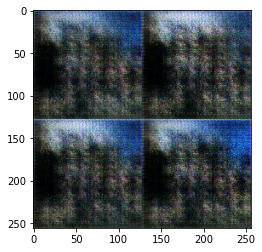

In [20]:
show_images = 5
# Plot the images from last epoch
data_images = helper.get_batch(glob(os.path.join("./generated_images/epoch_" + str(num_epochs-1) +"/", '*.jpg'))[:show_images], 64, 64, 'RGB')
plt.imshow(helper.images_square_grid(data_images, 'RGB'))